# Week 12: U-Net
## Convolutional Networks for Image Segmentation

Olaf Ronneberger, Philipp Fischer, and Thomas Brox
2015

U-Net is a segmentation network whose architecture resembles the letter "u". The network "contracts to capture context and a symmetric expanding path that enables precise localization" (Ronnenberger et al. 2015).

![unet.PNG](unet.PNG)

The example provided here will use a dataset of images we chose to use is labeled to classify cars. There are two labels in these images ('car' and 'not car'). 


## Weighted Mask

The use of the standard categorical cross-entropy loss function in U-net can be problematic for biomedical image segmentation:  
* When using this loss function, the model is rewarded for classifying narrow cell boundaries as being in-cell pixels because they are close to many other in-cell pixels  
* While this might not reduce the overall accuracy much, it reduces the usefulness of the segmentation result  
* To mitigate this problem, the implementation from the paper includes a weight map that is used to add a weight value to the loss function.  

This weight map is calculated as follows:

$$\Large
w(x) = w_c(x) + w_0\ \cdot\ exp\ (-\ \frac{(d_1(x) + d_2(x))^2}{2 \sigma^2})
$$

$$\small  
x\ is\ the\ current\ pixel \\  
w_c\ is\ the\ class\ weighting\ that\ upweights\ classes\ differently \\  
d_1\ is\ the\ distance\ to\ the\ nearest\ cell\ boundary \\  
d_2\ is\ the\ distance\ to\ the\ second\ nearest\ cell\ boundary \\  
w_0\ and\ \sigma\ are\ constants\ that\ scale\ the\ weighting $$  
  
### Example:  
Let's implement this in code. First we need to develop a function that can generate random cells to simulate a microscopy image:


In [1]:
# from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_random_circles(n = 50, d = 100, cell_size = 20):

  """
  Generate a numpy array that is a simulated mask for an image of 
  cells where the in-cell pixels are 1 and background pixels are 0. 
  Used as prelimiary generator for unet_weight_map function.

  Parameters
  ----------
  n:  int
      Number of cells to be created
  d:  int
      Dictionary of weight classes.
  Returns
  -------
  Numpy array
      Simulated mask for a cell-image. A 2D array of shape (d,d).
  """
  # Generate coordinates for random circles
  circles = np.random.randint(0, d, (n, 3))
  # Ensure radius (3rd col) is between d/3 and d
  circles[:,2] = np.interp(circles[:,2], (circles[:,2].max(), circles[:,2].max()), (d/3,d))

  # Generate background for simluated cell image 
  x = np.zeros((d, d), dtype=int)
  
  # Iterate over circles and insert into simulated image
  for x0, y0, r in circles:
    copy_x = deepcopy(x)
    # Generate new 2D array with circle of pixels with value 1 for current circle
    new_x = np.fromfunction(lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*cell_size)**2, x.shape)
    
    # Add new circle to cell map
    for i in range(1,len(new_x)-1):
      for j in range(1,len(new_x[0])-1):
        # Only add to cell map if neighbours are 0
        if new_x[i][j] == True and x[i-1][j]==0 and x[i-1][j-1]==0 and x[i][j-1]==0 and x[i][j+1]==0 and x[i+1][j+1]==0 and x[i+1][j]==0 and x[i+1][j-1]==0 and x[i-1][j+1]==0:
          copy_x[i][j] += new_x[i][j]
    x += copy_x
  
  # Clip values above 1 to a max of 1
  x = np.clip(x, 0, 1)

  # Return simulated cell map
  return x

Second we need to implement the weighting function that weights each pixel in the image based on it's distance to the nearest cell boundaries:

In [2]:

def unet_weight_map(y, wc=None, w0 = 10, sigma = 5):

  """
  Generate weight maps as specified in the U-Net paper
  for boolean mask.
  
  "U-Net: Convolutional Networks for Biomedical Image Segmentation"
  https://arxiv.org/pdf/1505.04597.pdf
  
  Parameters
  ----------
  mask: Numpy array
      2D array of shape (image_height, image_width) representing binary mask
      of objects.
  wc: dict
      Dictionary of weight classes.
  w0: int
      Border weight parameter.
  sigma: int
      Border width parameter.
  Returns
  -------
  Numpy array
      Training weights. A 2D array of shape (image_height, image_width).
  """
  
  # Grab labels from input
  labels = label(y)
  no_labels = labels == 0
  label_ids = sorted(np.unique(labels))[1:]

  # Check for circles in y
  if len(label_ids) > 1:
    # Calculate distances
    distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))
    for i, label_id in enumerate(label_ids):
      distances[:,:,i] = distance_transform_edt(labels != label_id)

    # Sort for nearest cell boundary distances
    distances = np.sort(distances, axis=2)
    d1 = distances[:,:,0]
    d2 = distances[:,:,1]
    
    # Calculate second term in weighting equation
    w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

    # Sum with class weights to produce weighted mask
    if wc:
      class_weights = np.zeros_like(y)
      for k, v in wc.items():
        class_weights[y == k] = v
      w = w + class_weights
  
  # If no circles we passed in to the function, return zeros
  else:
    w = np.zeros_like(y)
  
  # Return weighted mask
  return w


Let's generate a simulated cell image mask and then weight the pixels of that mask. You need to choose weighting values for the two classes, cell and non-cell:

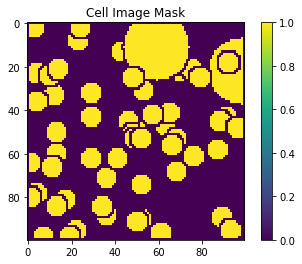

sumCellPixels0: 6445     sumCellPixels1: 3555
background: 0.6445    cells: 0.3555
background_1: 1.5515903801396431    cells_1: 2.8129395218002813
Class Weighting: {0: 1.5515903801396431, 1: 2.8129395218002813}


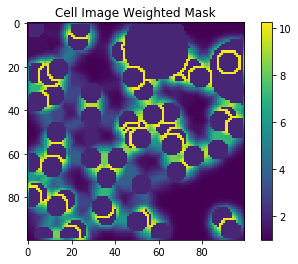

In [14]:
# Generate simulated cell mask 
num_cells        = 60
image_dimensions = 100
cell_size        = 15
y = generate_random_circles(num_cells, image_dimensions, cell_size)

# Display cell mask
plt.imshow(y)
plt.title('Cell Image Mask')
plt.colorbar()
plt.show()

# inversely proportional to class frequency:like they did in the paper
sumCellPixels0 = 0
sumCellPixels1 = 0
 

totalNumPixels = y.shape[0] * y.shape[1]

for row in y:
    for i in row:
        if i == 0:
            sumCellPixels0 += 1
        if i == 1:
            sumCellPixels1 += 1
    
        
print(f'sumCellPixels0: {sumCellPixels0}     sumCellPixels1: {sumCellPixels1}')

background = sumCellPixels0/totalNumPixels
cells = sumCellPixels1/totalNumPixels


print(f'background: {background}    cells: {cells}')

# inverse proportions:
background_1 = 1/background
cells_1 = 1/cells


print(f'background_1: {background_1}    cells_1: {cells_1}')

# Weighting for pixels assigned to the two classes
class_weighting = {
  # TODO: Choose weighting values for the classes in the cell mask - they are currently set to 0.
  0: background_1, # background
  1: cells_1  # cells
}


print('Class Weighting:', class_weighting)

# Generate weighted map
w = unet_weight_map(y, class_weighting)

# Display weighted mask
plt.imshow(w)
plt.title('Cell Image Weighted Mask')
plt.colorbar()
plt.show()

**TO DO: Try adjusting the weighting of the class in the class_weighting dictionary (or other parameters) and see what impact that has on the final weighted mask.**

# Implementing U-Net

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as TF

We use the double convolution quite a lot in this architecture so let's implement it as a reusable code block.

In [16]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),  # 3x3 convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


Now let's devise the network using Pytorch functionality.

In [17]:

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

For a sanity check, let's just make sure that we are getting a prediction that is the shape we would expect.

**QUESTION: Given the shape of the torch.randn() and the fact that we're using padding, what do you expect the output shape to be?**

**Answer: if we're using padding, we would expect the output shape to be the same as the input shape, unlike in the paper where they did not use padding. This resulted in an output slightly smaller than the input.** 


In [20]:
x = torch.randn((3, 1, 50, 50))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
assert preds.shape == x.shape


### Dataset Loader
Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches”.

In [21]:
from PIL import Image
from torch.utils.data import Dataset

class CarDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

### Useful Utility Functions
Some of the operations we perform can be functionalized to save on repetition. The two examples below are getting the data loaders and validating the model.

In [22]:
from torch.utils.data import DataLoader

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
):
    train_ds = CarDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = CarDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

def validation_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x
            y = y.unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
    print(f"Got {num_correct}/{num_pixels} pixels with acc {num_correct/num_pixels*100:.2f}")
    model.train()

### Training Function

In [23]:
def train_fn(loader, model, optimizer, loss_fn):

    for batch_idx, (data, targets) in enumerate(loader):

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets.float().unsqueeze(1))

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Iter: {batch_idx+1}/{len(loader.dataset)}, Loss: {loss.item():.04f}")


### Hyperparameters
Choose hyperparameters for the model. Experiment with the learning rate and batch size.

In [38]:
# Hyperparameters

# TODO: experiment with different values
LEARNING_RATE = 1e-3
BATCH_SIZE = 1

IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
LOAD_MODEL = False

cwd = os.getcwd()

TRAIN_IMG_DIR = os.path.join(cwd, "data", "train_images")
TRAIN_MASK_DIR = os.path.join(cwd, "data", "train_masks")
VAL_IMG_DIR = os.path.join(cwd, "data", "val_images")
VAL_MASK_DIR = os.path.join(cwd, "data", "val_masks")

### Data Transformation
The images in this dataset are quite large, so we will need to reduce the size in order to make the training time a little more reasonable. While this might sacrifice some accuracy due to compression, we can run more data through the model during training this way.

In [39]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)


### Training the Model

**Question: Why do we use the BCEWithLogitsLoss function for training the model?**  
The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

**Answer: "This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability." - from that doc ^^ 
Because we are segmenting a single channel output. BCE with Logits Loss will allow us to pass in one positive weight parameter meaning 1-po** 

**Question: Given the authors of the original U-Net paper chose SGD, is Adam the best optimizer for this implementation?**  
Consider trying [a couple of different ones](https://pytorch.org/docs/stable/optim.html#algorithms) and see what happens.

In [40]:
model = UNET(in_channels=3, out_channels=1)

loss_fn = nn.BCEWithLogitsLoss()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)

train_fn(train_loader, model, optimizer, loss_fn)


Iter: 1/224, Loss: 0.7144
Iter: 2/224, Loss: 0.4027
Iter: 3/224, Loss: 0.5898
Iter: 4/224, Loss: 0.4915
Iter: 5/224, Loss: 0.5270
Iter: 6/224, Loss: 0.5276
Iter: 7/224, Loss: 0.3978
Iter: 8/224, Loss: 0.4221
Iter: 9/224, Loss: 0.3435
Iter: 10/224, Loss: 0.4652
Iter: 11/224, Loss: 0.4366
Iter: 12/224, Loss: 0.4288
Iter: 13/224, Loss: 0.3240
Iter: 14/224, Loss: 0.2828
Iter: 15/224, Loss: 0.3828
Iter: 16/224, Loss: 0.2798
Iter: 17/224, Loss: 0.2911
Iter: 18/224, Loss: 0.3378
Iter: 19/224, Loss: 0.3482
Iter: 20/224, Loss: 0.2584
Iter: 21/224, Loss: 0.2854
Iter: 22/224, Loss: 0.2466
Iter: 23/224, Loss: 0.2621
Iter: 24/224, Loss: 0.2856
Iter: 25/224, Loss: 0.2520
Iter: 26/224, Loss: 0.2206
Iter: 27/224, Loss: 0.2509
Iter: 28/224, Loss: 0.2311
Iter: 29/224, Loss: 0.2412
Iter: 30/224, Loss: 0.2072
Iter: 31/224, Loss: 0.2331
Iter: 32/224, Loss: 0.2089
Iter: 33/224, Loss: 0.2255
Iter: 34/224, Loss: 0.1976
Iter: 35/224, Loss: 0.1743
Iter: 36/224, Loss: 0.2312
Iter: 37/224, Loss: 0.2188
Iter: 38/2

KeyboardInterrupt: 

### Validating the Model

In [30]:
validation_accuracy(val_loader, model)

Got 2034704/2457600 pixels with acc 82.79


Let's visualise a couple randomly selected validation predictions and see how well the model did.

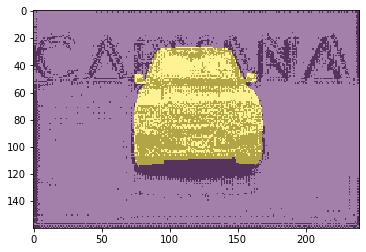

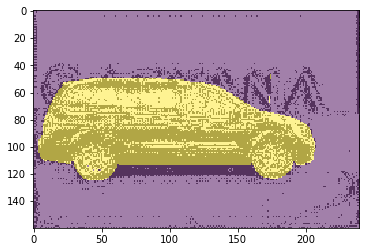

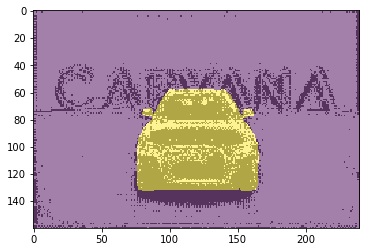

In [31]:
# TODO: how many predictions do you want to visualize?
num_predictions = 3

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()
  

**Question: What you do notice about the predicted mask that is less than optimal?**  

**Answer: I didn't notice anything that would be less than optimal in this version of the model (Adam). However, when switching to SGD we can see more of the background in the image, the accuracy is slightly lower, and the loss was slower to converge, but the predicted segmentation looks very similar.**

### Data Augmentation
Let's train the model on some new data (in a sense). We can augment the data that we feed to the model by performing horizontal flips on the images of the cars, or even changing the distribution of the normalized values. 

In [41]:
train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)


Now continue training the model:

In [42]:
train_fn(train_loader, model, optimizer, loss_fn)

Iter: 1/224, Loss: 0.1447
Iter: 2/224, Loss: 0.1392
Iter: 3/224, Loss: 0.1352
Iter: 4/224, Loss: 0.1601
Iter: 5/224, Loss: 0.1232
Iter: 6/224, Loss: 0.1376
Iter: 7/224, Loss: 0.1626
Iter: 8/224, Loss: 0.1297
Iter: 9/224, Loss: 0.1336
Iter: 10/224, Loss: 0.1441
Iter: 11/224, Loss: 0.1373
Iter: 12/224, Loss: 0.1479
Iter: 13/224, Loss: 0.1515
Iter: 14/224, Loss: 0.1416
Iter: 15/224, Loss: 0.1429
Iter: 16/224, Loss: 0.1326
Iter: 17/224, Loss: 0.1233
Iter: 18/224, Loss: 0.1215
Iter: 19/224, Loss: 0.1169
Iter: 20/224, Loss: 0.1222
Iter: 21/224, Loss: 0.1023
Iter: 22/224, Loss: 0.1200
Iter: 23/224, Loss: 0.1440
Iter: 24/224, Loss: 0.1667
Iter: 25/224, Loss: 0.1834
Iter: 26/224, Loss: 0.1154
Iter: 27/224, Loss: 0.1161
Iter: 28/224, Loss: 0.1552
Iter: 29/224, Loss: 0.1439
Iter: 30/224, Loss: 0.1308
Iter: 31/224, Loss: 0.1043


KeyboardInterrupt: 

Take a look at some of the model predictions.  
  
**Question: How has the model performance changed and why?** 

**It looks like the loss drops lower using augmented data. It's hard to say whether this is an improvement because I haven't seen the whole corpus of training data fed into the model. Some of the cars may be at varing angles so augmenting data, maybe that adds MORE data which would be the main benefit (?)**

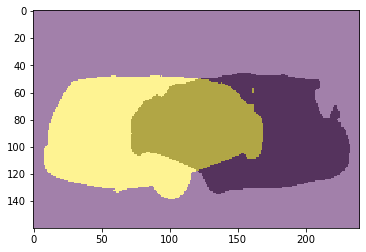

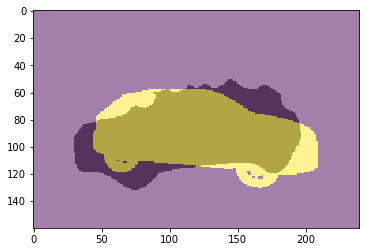

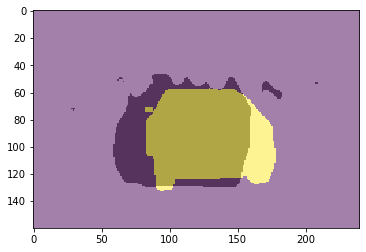

In [43]:
# TODO: how many predictions do you want to visualize?
num_predictions = 3

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()


**As an optional final task, try training a new model on variations of augmented data and see how the performance changes with different augmentations.** 